# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [ ]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170498071/170498071 [==============================] - 4s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

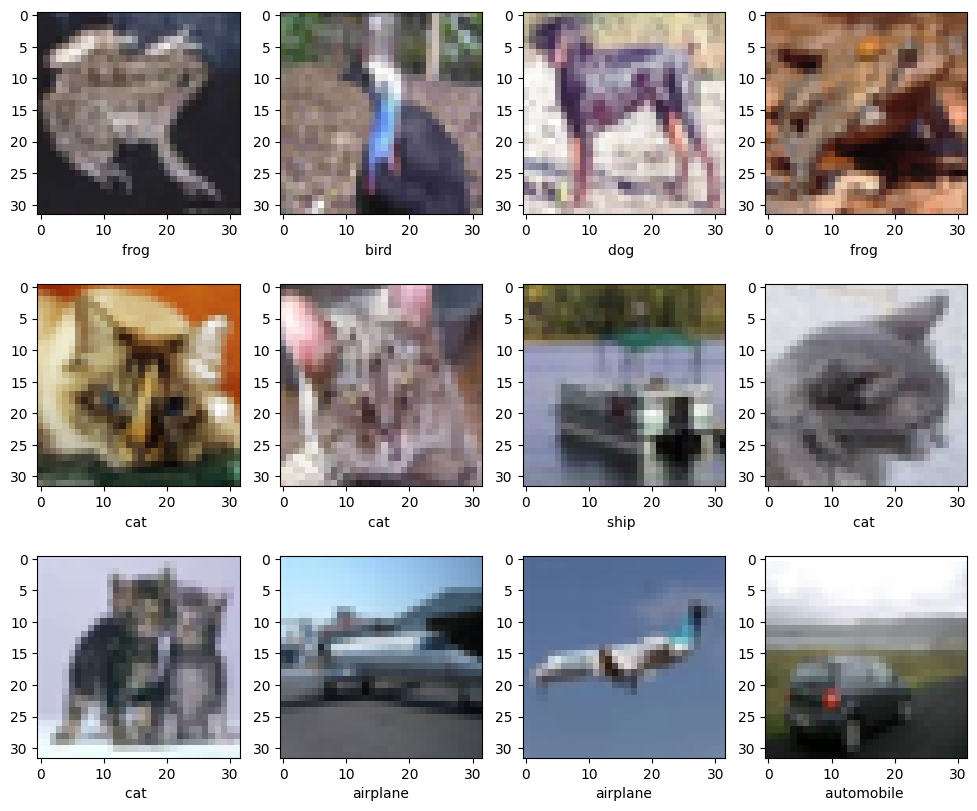

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K
from sklearn.metrics import accuracy_score

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')

])

In [ ]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 1s 819ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import logging

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

In [ ]:
# wandb.init(
#     project="NN-projo",
#     config={
#         "batch_size": 128,
#         "learning_rate": 0.01,
#         "dataset": "CIFAR-100",
#     },
# )

In [ ]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [ ]:
## TODO
# %%wandb
model.compile(optimizer='sgd',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'],

)
model.fit(X_train, y_train, batch_size=16, epochs=32, validation_data=[X_val, y_val], callbacks=callbacks, validation_split=0.2)

Epoch 1/32
2500/2500 [==============================] - 42s 16ms/step - loss: 1.8929 - accuracy: 0.3178 - val_loss: 1.7463 - val_accuracy: 0.3651
Epoch 2/32
  11/2500 [..............................] - ETA: 27s - loss: 1.7367 - accuracy: 0.3864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 [==============================] - 35s 14ms/step - loss: 1.6407 - accuracy: 0.4137 - val_loss: 1.5751 - val_accuracy: 0.4364
Epoch 3/32
2500/2500 [==============================] - 36s 14ms/step - loss: 1.5481 - accuracy: 0.4517 - val_loss: 1.5246 - val_accuracy: 0.4561
Epoch 4/32
2500/2500 [==============================] - 37s 15ms/step - loss: 1.4793 - accuracy: 0.4760 - val_loss: 1.5009 - val_accuracy: 0.4671
Epoch 5/32
2500/2500 [==============================] - 35s 14ms/step - loss: 1.4265 - accuracy: 0.4938 - val_loss: 1.4690 - val_accuracy: 0.4805
Epoch 6/32
2500/2500 [==============================] - 36s 14ms/step - loss: 1.3826 - accuracy: 0.5091 - val_loss: 1.4157 - val_accuracy: 0.4986
Epoch 7/32
2500/2500 [==============================] - 38s 15ms/step - loss: 1.3430 - accuracy: 0.5252 - val_loss: 1.4221 - val_accuracy: 0.4995
Epoch 8/32
2500/2500 [==============================] - 35s 14ms/step - loss: 1.3051 - accuracy: 0.5366 - val_loss: 1.4062 - val_accura

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 2s 6ms/step

 Test_acc = 0.5234
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
## TODO
new_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [ ]:
## TODO
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
new_model.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 30s 14ms/step - loss: 1.5981 - accuracy: 0.4259 - val_loss: 1.3775 - val_accuracy: 0.5154
Epoch 2/32
  11/2000 [..............................] - ETA: 20s - loss: 1.3779 - accuracy: 0.5114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 28s 14ms/step - loss: 1.3067 - accuracy: 0.5357 - val_loss: 1.3097 - val_accuracy: 0.5351
Epoch 3/32
2000/2000 [==============================] - 29s 14ms/step - loss: 1.2017 - accuracy: 0.5732 - val_loss: 1.2673 - val_accuracy: 0.5550
Epoch 4/32
2000/2000 [==============================] - 29s 14ms/step - loss: 1.1228 - accuracy: 0.6039 - val_loss: 1.2455 - val_accuracy: 0.5575
Epoch 5/32
2000/2000 [==============================] - 29s 14ms/step - loss: 1.0608 - accuracy: 0.6277 - val_loss: 1.1913 - val_accuracy: 0.5851
Epoch 6/32
2000/2000 [==============================] - 28s 14ms/step - loss: 1.0008 - accuracy: 0.6474 - val_loss: 1.2113 - val_accuracy: 0.5760
Epoch 7/32
2000/2000 [==============================] - 28s 14ms/step - loss: 0.9513 - accuracy: 0.6665 - val_loss: 1.2422 - val_accuracy: 0.5724
Epoch 8/32
2000/2000 [==============================] - 28s 14ms/step - loss: 0.9020 - accuracy: 0.6824 - val_loss: 1.2141 - val_accura

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.5861
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [ ]:
!rm -rf ./logs

In [ ]:
from tensorflow.keras import optimizers

## TODO
optimizers = {...}

In [ ]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

In [ ]:
!pwd

Прокомментируйте полученные результаты.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
# попробовал через созданный класс, но не уверен что полность разобрался

In [ ]:
models = Models(keras.Sequential())

In [ ]:
models.add(L.InputLayer(input_shape=X_train.shape[1:]))
models.add(L.Conv2D(filters=10,
                      kernel_size=(3, 3),
                      padding='same',
                      activation='relu'))
models.add(L.MaxPooling2D())
models.add(L.Flatten())
models.add(L.Dense(100, activation='relu'))
models.add(L.Dense(10, activation='softmax'))

In [ ]:
my_models = tf.keras.models.Sequential([models['base_model']])

In [ ]:
my_models.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
my_models.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 12s 4ms/step - loss: 1.5737 - accuracy: 0.4344 - val_loss: 1.3882 - val_accuracy: 0.5013
Epoch 2/32
  52/2000 [..............................] - ETA: 5s - loss: 1.3273 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 8s 4ms/step - loss: 1.3037 - accuracy: 0.5365 - val_loss: 1.3160 - val_accuracy: 0.5311
Epoch 3/32
2000/2000 [==============================] - 8s 4ms/step - loss: 1.2005 - accuracy: 0.5743 - val_loss: 1.2672 - val_accuracy: 0.5552
Epoch 4/32
2000/2000 [==============================] - 7s 4ms/step - loss: 1.1313 - accuracy: 0.5994 - val_loss: 1.2875 - val_accuracy: 0.5534
Epoch 5/32
2000/2000 [==============================] - 8s 4ms/step - loss: 1.0667 - accuracy: 0.6241 - val_loss: 1.2341 - val_accuracy: 0.5654
Epoch 6/32
2000/2000 [==============================] - 8s 4ms/step - loss: 1.0144 - accuracy: 0.6420 - val_loss: 1.2128 - val_accuracy: 0.5755
Epoch 7/32
2000/2000 [==============================] - 8s 4ms/step - loss: 0.9657 - accuracy: 0.6601 - val_loss: 1.2142 - val_accuracy: 0.5851
Epoch 8/32
2000/2000 [==============================] - 7s 4ms/step - loss: 0.9217 - accuracy: 0.6749 - val_loss: 1.1882 - val_accuracy: 0.5951
Epo

In [ ]:
predict_x = my_models.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.5843
 Not bad!


In [ ]:
# модель с BatchNormalization в сверточном слое
model_task_14 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_task_14.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_task_14.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 40s 19ms/step - loss: 1.4842 - accuracy: 0.4788 - val_loss: 1.3182 - val_accuracy: 0.5397
Epoch 2/32
   9/2000 [..............................] - ETA: 30s - loss: 1.1189 - accuracy: 0.6597

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 39s 19ms/step - loss: 1.1612 - accuracy: 0.5904 - val_loss: 1.3859 - val_accuracy: 0.5304
Epoch 3/32
2000/2000 [==============================] - 40s 20ms/step - loss: 1.0108 - accuracy: 0.6439 - val_loss: 1.4048 - val_accuracy: 0.5401
Epoch 4/32
2000/2000 [==============================] - 38s 19ms/step - loss: 0.8661 - accuracy: 0.6928 - val_loss: 1.3035 - val_accuracy: 0.5730
Epoch 5/32
2000/2000 [==============================] - 39s 19ms/step - loss: 0.7334 - accuracy: 0.7411 - val_loss: 1.3405 - val_accuracy: 0.5801
Epoch 6/32
2000/2000 [==============================] - 38s 19ms/step - loss: 0.6145 - accuracy: 0.7804 - val_loss: 1.5091 - val_accuracy: 0.5710
Epoch 7/32
2000/2000 [==============================] - 38s 19ms/step - loss: 0.5153 - accuracy: 0.8218 - val_loss: 1.6245 - val_accuracy: 0.5701


In [ ]:
predict_x = model_task_14.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.571
 Not bad!


In [ ]:
# модель с BatchNormalization в сверточном и полносвязном слоях
model_task_24 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model_task_24.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_task_24.fit(X_train, y_train, batch_size=16, epochs=32, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 41s 20ms/step - loss: 1.5054 - accuracy: 0.4727 - val_loss: 1.2967 - val_accuracy: 0.5339
Epoch 2/32
   8/2000 [..............................] - ETA: 32s - loss: 1.2921 - accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 39s 20ms/step - loss: 1.2485 - accuracy: 0.5612 - val_loss: 1.7124 - val_accuracy: 0.5106
Epoch 3/32
2000/2000 [==============================] - 40s 20ms/step - loss: 1.1406 - accuracy: 0.5997 - val_loss: 1.2205 - val_accuracy: 0.5734
Epoch 4/32
2000/2000 [==============================] - 40s 20ms/step - loss: 1.0588 - accuracy: 0.6274 - val_loss: 1.2609 - val_accuracy: 0.5665
Epoch 5/32
2000/2000 [==============================] - 40s 20ms/step - loss: 0.9817 - accuracy: 0.6569 - val_loss: 1.1709 - val_accuracy: 0.5976
Epoch 6/32
2000/2000 [==============================] - 40s 20ms/step - loss: 0.9199 - accuracy: 0.6793 - val_loss: 1.6417 - val_accuracy: 0.4766
Epoch 7/32
2000/2000 [==============================] - 40s 20ms/step - loss: 0.8537 - accuracy: 0.7024 - val_loss: 1.2588 - val_accuracy: 0.5914
Epoch 8/32
2000/2000 [==============================] - 40s 20ms/step - loss: 0.7986 - accuracy: 0.7218 - val_loss: 1.2212 - val_accura

In [ ]:
predict_x = model_task_24.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 4s 13ms/step

 Test_acc = 0.6031
 Not bad!


Прокомментируйте полученные результаты.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [ ]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [ ]:
## инходный вариант
final_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

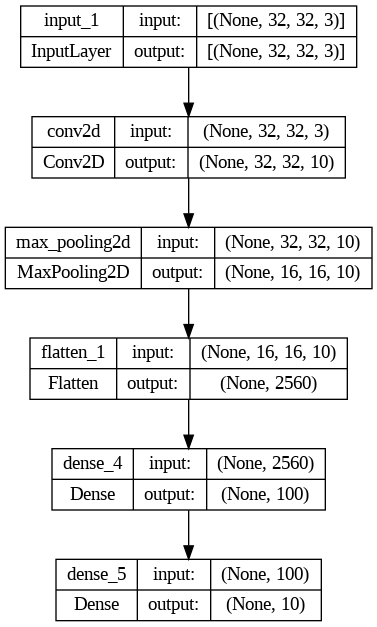

In [ ]:
tf.keras.utils.plot_model(final_model, '123.png', show_shapes=True)

In [ ]:
## TODO
final_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2500/2500 [==============================] - ETA: 0s - loss: 1.6802 - accuracy: 0.3921

2500/2500 [==============================] - 58s 23ms/step - loss: 1.6802 - accuracy: 0.3921
Epoch 2/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.4642 - accuracy: 0.4758

2500/2500 [==============================] - 57s 23ms/step - loss: 1.4642 - accuracy: 0.4758
Epoch 3/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.4074 - accuracy: 0.4950

2500/2500 [==============================] - 57s 23ms/step - loss: 1.4074 - accuracy: 0.4950
Epoch 4/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.3596 - accuracy: 0.5111

2500/2500 [==============================] - 58s 23ms/step - loss: 1.3595 - accuracy: 0.5112
Epoch 5/32
2500/2500 [==============================] - ETA: 0s - loss: 1.3307 - accuracy: 0.5214

2500/2500 [==============================] - 57s 23ms/step - loss: 1.3307 - accuracy: 0.5214
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 1.3060 - accuracy: 0.5310

2500/2500 [==============================] - 56s 22ms/step - loss: 1.3060 - accuracy: 0.5310
Epoch 7/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.2813 - accuracy: 0.5422

2500/2500 [==============================] - 56s 22ms/step - loss: 1.2815 - accuracy: 0.5422
Epoch 8/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2650 - accuracy: 0.5486

2500/2500 [==============================] - 58s 23ms/step - loss: 1.2648 - accuracy: 0.5487
Epoch 9/32
2500/2500 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.5553

2500/2500 [==============================] - 57s 23ms/step - loss: 1.2446 - accuracy: 0.5553
Epoch 10/32
2500/2500 [==============================] - ETA: 0s - loss: 1.2312 - accuracy: 0.5603

2500/2500 [==============================] - 56s 23ms/step - loss: 1.2312 - accuracy: 0.5603
Epoch 11/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2286 - accuracy: 0.5636

2500/2500 [==============================] - 57s 23ms/step - loss: 1.2286 - accuracy: 0.5636
Epoch 12/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2136 - accuracy: 0.5674

2500/2500 [==============================] - 56s 22ms/step - loss: 1.2137 - accuracy: 0.5673
Epoch 13/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2054 - accuracy: 0.5697

2500/2500 [==============================] - 57s 23ms/step - loss: 1.2055 - accuracy: 0.5696
Epoch 14/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1992 - accuracy: 0.5732

2500/2500 [==============================] - 57s 23ms/step - loss: 1.1996 - accuracy: 0.5730
Epoch 15/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1845 - accuracy: 0.5779

2500/2500 [==============================] - 56s 22ms/step - loss: 1.1845 - accuracy: 0.5778
Epoch 16/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1802 - accuracy: 0.5797

2500/2500 [==============================] - 56s 22ms/step - loss: 1.1803 - accuracy: 0.5797
Epoch 17/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1734 - accuracy: 0.5784

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1734 - accuracy: 0.5784
Epoch 18/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1706 - accuracy: 0.5837

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1706 - accuracy: 0.5837
Epoch 19/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1723 - accuracy: 0.5836

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1723 - accuracy: 0.5836
Epoch 20/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1592 - accuracy: 0.5900

2500/2500 [==============================] - 56s 22ms/step - loss: 1.1592 - accuracy: 0.5900
Epoch 21/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1648 - accuracy: 0.5841

2500/2500 [==============================] - 57s 23ms/step - loss: 1.1650 - accuracy: 0.5840
Epoch 22/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1532 - accuracy: 0.5888

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1533 - accuracy: 0.5888
Epoch 23/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1471 - accuracy: 0.5944

2500/2500 [==============================] - 57s 23ms/step - loss: 1.1470 - accuracy: 0.5944
Epoch 24/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1467 - accuracy: 0.5912

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1465 - accuracy: 0.5912
Epoch 25/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1412 - accuracy: 0.5944

2500/2500 [==============================] - 57s 23ms/step - loss: 1.1412 - accuracy: 0.5945
Epoch 26/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1416 - accuracy: 0.5977

2500/2500 [==============================] - 56s 22ms/step - loss: 1.1416 - accuracy: 0.5977
Epoch 27/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1340 - accuracy: 0.5972

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1340 - accuracy: 0.5972
Epoch 28/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1316 - accuracy: 0.5977

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1316 - accuracy: 0.5977
Epoch 29/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1297 - accuracy: 0.5992

2500/2500 [==============================] - 56s 23ms/step - loss: 1.1299 - accuracy: 0.5990
Epoch 30/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1293 - accuracy: 0.6004

2500/2500 [==============================] - 57s 23ms/step - loss: 1.1291 - accuracy: 0.6005
Epoch 31/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1271 - accuracy: 0.6016

2500/2500 [==============================] - 59s 24ms/step - loss: 1.1271 - accuracy: 0.6016
Epoch 32/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1234 - accuracy: 0.6001

2500/2500 [==============================] - 56s 22ms/step - loss: 1.1233 - accuracy: 0.6001


Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=final_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 2s 8ms/step

 Test_acc = 0.615


In [ ]:
# вариант с sgd
final_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.3166 - accuracy: 0.5345

2500/2500 [==============================] - 53s 21ms/step - loss: 1.3168 - accuracy: 0.5343
Epoch 2/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.2565 - accuracy: 0.5513

2500/2500 [==============================] - 52s 21ms/step - loss: 1.2565 - accuracy: 0.5512
Epoch 3/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.2425 - accuracy: 0.5568

2500/2500 [==============================] - 53s 21ms/step - loss: 1.2423 - accuracy: 0.5568
Epoch 4/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1864 - accuracy: 0.5806

2500/2500 [==============================] - 52s 21ms/step - loss: 1.1864 - accuracy: 0.5806
Epoch 5/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.6041

2500/2500 [==============================] - 52s 21ms/step - loss: 1.1198 - accuracy: 0.6041
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1216 - accuracy: 0.6036

2500/2500 [==============================] - 53s 21ms/step - loss: 1.1216 - accuracy: 0.6036
Epoch 7/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1180 - accuracy: 0.6041

2500/2500 [==============================] - 52s 21ms/step - loss: 1.1184 - accuracy: 0.6039
Epoch 8/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1112 - accuracy: 0.6073

2500/2500 [==============================] - 52s 21ms/step - loss: 1.1111 - accuracy: 0.6074
Epoch 9/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1116 - accuracy: 0.6060

2500/2500 [==============================] - 53s 21ms/step - loss: 1.1114 - accuracy: 0.6061
Epoch 10/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1018 - accuracy: 0.6115

2500/2500 [==============================] - 53s 21ms/step - loss: 1.1020 - accuracy: 0.6115
Epoch 11/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1047 - accuracy: 0.6108

2500/2500 [==============================] - 51s 20ms/step - loss: 1.1048 - accuracy: 0.6107
Epoch 12/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1064 - accuracy: 0.6096

2500/2500 [==============================] - 53s 21ms/step - loss: 1.1065 - accuracy: 0.6095
Epoch 13/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0999 - accuracy: 0.6117

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0999 - accuracy: 0.6117
Epoch 14/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1013 - accuracy: 0.6104

2500/2500 [==============================] - 53s 21ms/step - loss: 1.1012 - accuracy: 0.6104
Epoch 15/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0983 - accuracy: 0.6121

2500/2500 [==============================] - 51s 20ms/step - loss: 1.0983 - accuracy: 0.6122
Epoch 16/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0953 - accuracy: 0.6142

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0956 - accuracy: 0.6141
Epoch 17/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0904 - accuracy: 0.6155

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0904 - accuracy: 0.6155
Epoch 18/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0942 - accuracy: 0.6134

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0944 - accuracy: 0.6134
Epoch 19/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0931 - accuracy: 0.6148

2500/2500 [==============================] - 52s 21ms/step - loss: 1.0931 - accuracy: 0.6148
Epoch 20/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0998 - accuracy: 0.6125

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0997 - accuracy: 0.6125
Epoch 21/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0922 - accuracy: 0.6155

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0928 - accuracy: 0.6153
Epoch 22/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0909 - accuracy: 0.6131

2500/2500 [==============================] - 51s 20ms/step - loss: 1.0908 - accuracy: 0.6132
Epoch 23/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0878 - accuracy: 0.6181

2500/2500 [==============================] - 53s 21ms/step - loss: 1.0878 - accuracy: 0.6181
Epoch 24/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0920 - accuracy: 0.6144

2500/2500 [==============================] - 54s 22ms/step - loss: 1.0917 - accuracy: 0.6147
Epoch 25/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0852 - accuracy: 0.6172

2500/2500 [==============================] - 51s 21ms/step - loss: 1.0850 - accuracy: 0.6173
Epoch 26/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0950 - accuracy: 0.6137

2500/2500 [==============================] - 84s 34ms/step - loss: 1.0950 - accuracy: 0.6137
Epoch 27/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0859 - accuracy: 0.6174

2500/2500 [==============================] - 84s 33ms/step - loss: 1.0858 - accuracy: 0.6174
Epoch 28/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0878 - accuracy: 0.6176

2500/2500 [==============================] - 85s 34ms/step - loss: 1.0877 - accuracy: 0.6177
Epoch 29/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 0.6190

2500/2500 [==============================] - 83s 33ms/step - loss: 1.0824 - accuracy: 0.6190
Epoch 30/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0891 - accuracy: 0.6153

2500/2500 [==============================] - 85s 34ms/step - loss: 1.0891 - accuracy: 0.6154
Epoch 31/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0860 - accuracy: 0.6167

2500/2500 [==============================] - 85s 34ms/step - loss: 1.0860 - accuracy: 0.6167
Epoch 32/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0880 - accuracy: 0.6121

2500/2500 [==============================] - 85s 34ms/step - loss: 1.0882 - accuracy: 0.6121


In [ ]:
predict_x=final_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 8s 23ms/step

 Test_acc = 0.6245


In [ ]:
# новый вариант с доп пулингом
final_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

     tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_model_3.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model_3.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2500/2500 [==============================] - ETA: 0s - loss: 1.9665 - accuracy: 0.2869

2500/2500 [==============================] - 66s 26ms/step - loss: 1.9665 - accuracy: 0.2869
Epoch 2/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.6398 - accuracy: 0.4091

2500/2500 [==============================] - 61s 24ms/step - loss: 1.6397 - accuracy: 0.4090
Epoch 3/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.4981 - accuracy: 0.4580

2500/2500 [==============================] - 64s 25ms/step - loss: 1.4980 - accuracy: 0.4582
Epoch 4/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.4170 - accuracy: 0.4922

2500/2500 [==============================] - 63s 25ms/step - loss: 1.4169 - accuracy: 0.4923
Epoch 5/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.3531 - accuracy: 0.5148

2500/2500 [==============================] - 61s 24ms/step - loss: 1.3533 - accuracy: 0.5147
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 1.3038 - accuracy: 0.5334

2500/2500 [==============================] - 61s 25ms/step - loss: 1.3038 - accuracy: 0.5334
Epoch 7/32
2500/2500 [==============================] - ETA: 0s - loss: 1.2618 - accuracy: 0.5478

2500/2500 [==============================] - 62s 25ms/step - loss: 1.2618 - accuracy: 0.5478
Epoch 8/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.2278 - accuracy: 0.5634

2500/2500 [==============================] - 62s 25ms/step - loss: 1.2276 - accuracy: 0.5634
Epoch 9/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2037 - accuracy: 0.5738

2500/2500 [==============================] - 61s 24ms/step - loss: 1.2036 - accuracy: 0.5739
Epoch 10/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1701 - accuracy: 0.5854

2500/2500 [==============================] - 66s 26ms/step - loss: 1.1701 - accuracy: 0.5853
Epoch 11/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1489 - accuracy: 0.5919

2500/2500 [==============================] - 61s 24ms/step - loss: 1.1489 - accuracy: 0.5920
Epoch 12/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1261 - accuracy: 0.5969

2500/2500 [==============================] - 62s 25ms/step - loss: 1.1261 - accuracy: 0.5969
Epoch 13/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1008 - accuracy: 0.6090

2500/2500 [==============================] - 62s 25ms/step - loss: 1.1006 - accuracy: 0.6090
Epoch 14/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0874 - accuracy: 0.6151

2500/2500 [==============================] - 62s 25ms/step - loss: 1.0872 - accuracy: 0.6151
Epoch 15/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0696 - accuracy: 0.6202

2500/2500 [==============================] - 60s 24ms/step - loss: 1.0696 - accuracy: 0.6202
Epoch 16/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0509 - accuracy: 0.6280

2500/2500 [==============================] - 64s 25ms/step - loss: 1.0510 - accuracy: 0.6280
Epoch 17/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0402 - accuracy: 0.6307

2500/2500 [==============================] - 62s 25ms/step - loss: 1.0402 - accuracy: 0.6307
Epoch 18/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0292 - accuracy: 0.6379

2500/2500 [==============================] - 63s 25ms/step - loss: 1.0293 - accuracy: 0.6378
Epoch 19/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0156 - accuracy: 0.6429

2500/2500 [==============================] - 64s 25ms/step - loss: 1.0156 - accuracy: 0.6429
Epoch 20/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0114 - accuracy: 0.6395

2500/2500 [==============================] - 64s 25ms/step - loss: 1.0114 - accuracy: 0.6395
Epoch 21/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9941 - accuracy: 0.6488

2500/2500 [==============================] - 63s 25ms/step - loss: 0.9940 - accuracy: 0.6488
Epoch 22/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.6553

2500/2500 [==============================] - 64s 26ms/step - loss: 0.9818 - accuracy: 0.6553
Epoch 23/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.6549

2500/2500 [==============================] - 64s 25ms/step - loss: 0.9744 - accuracy: 0.6549
Epoch 24/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9618 - accuracy: 0.6597

2500/2500 [==============================] - 64s 26ms/step - loss: 0.9618 - accuracy: 0.6597
Epoch 25/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.6639

2500/2500 [==============================] - 62s 25ms/step - loss: 0.9566 - accuracy: 0.6639
Epoch 26/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.6647

2500/2500 [==============================] - 63s 25ms/step - loss: 0.9514 - accuracy: 0.6647
Epoch 27/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9385 - accuracy: 0.6700

2500/2500 [==============================] - 64s 26ms/step - loss: 0.9385 - accuracy: 0.6700
Epoch 28/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.6720

2500/2500 [==============================] - 62s 25ms/step - loss: 0.9325 - accuracy: 0.6720
Epoch 29/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.9240 - accuracy: 0.6729

2500/2500 [==============================] - 62s 25ms/step - loss: 0.9240 - accuracy: 0.6729
Epoch 30/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.9155 - accuracy: 0.6768

2500/2500 [==============================] - 64s 26ms/step - loss: 0.9157 - accuracy: 0.6767
Epoch 31/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9086 - accuracy: 0.6785

2500/2500 [==============================] - 65s 26ms/step - loss: 0.9087 - accuracy: 0.6785
Epoch 32/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9000 - accuracy: 0.6819

2500/2500 [==============================] - 62s 25ms/step - loss: 0.9000 - accuracy: 0.6819


In [ ]:
predict_x=final_model_3.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 11ms/step

 Test_acc = 0.6914


In [ ]:
# модель с BatchNormalization в каждом слое
final_model_4 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

     tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

final_model_4.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model_4.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

predict_x=final_model_4.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

Epoch 1/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.6222 - accuracy: 0.4198

2500/2500 [==============================] - 76s 30ms/step - loss: 1.6218 - accuracy: 0.4200
Epoch 2/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.3917 - accuracy: 0.5035

2500/2500 [==============================] - 75s 30ms/step - loss: 1.3919 - accuracy: 0.5034
Epoch 3/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.2966 - accuracy: 0.5384

2500/2500 [==============================] - 74s 29ms/step - loss: 1.2964 - accuracy: 0.5386
Epoch 4/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2358 - accuracy: 0.5639

2500/2500 [==============================] - 77s 31ms/step - loss: 1.2358 - accuracy: 0.5639
Epoch 5/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1972 - accuracy: 0.5763

2500/2500 [==============================] - 75s 30ms/step - loss: 1.1971 - accuracy: 0.5763
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.5878

2500/2500 [==============================] - 77s 31ms/step - loss: 1.1735 - accuracy: 0.5878
Epoch 7/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.5938

2500/2500 [==============================] - 77s 31ms/step - loss: 1.1450 - accuracy: 0.5938
Epoch 8/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1238 - accuracy: 0.6042

2500/2500 [==============================] - 75s 30ms/step - loss: 1.1238 - accuracy: 0.6041
Epoch 9/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.6105

2500/2500 [==============================] - 74s 29ms/step - loss: 1.1067 - accuracy: 0.6105
Epoch 10/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0863 - accuracy: 0.6194

2500/2500 [==============================] - 75s 30ms/step - loss: 1.0864 - accuracy: 0.6193
Epoch 11/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0726 - accuracy: 0.6274

2500/2500 [==============================] - 74s 30ms/step - loss: 1.0725 - accuracy: 0.6275
Epoch 12/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0651 - accuracy: 0.6266

2500/2500 [==============================] - 79s 32ms/step - loss: 1.0650 - accuracy: 0.6266
Epoch 13/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0526 - accuracy: 0.6322

2500/2500 [==============================] - 77s 31ms/step - loss: 1.0526 - accuracy: 0.6322
Epoch 14/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0466 - accuracy: 0.6328

2500/2500 [==============================] - 76s 31ms/step - loss: 1.0469 - accuracy: 0.6327
Epoch 15/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.6404

2500/2500 [==============================] - 75s 30ms/step - loss: 1.0283 - accuracy: 0.6404
Epoch 16/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0188 - accuracy: 0.6433

2500/2500 [==============================] - 74s 30ms/step - loss: 1.0190 - accuracy: 0.6432
Epoch 17/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0084 - accuracy: 0.6470

2500/2500 [==============================] - 74s 29ms/step - loss: 1.0086 - accuracy: 0.6469
Epoch 18/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0106 - accuracy: 0.6463

2500/2500 [==============================] - 74s 29ms/step - loss: 1.0106 - accuracy: 0.6463
Epoch 19/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9951 - accuracy: 0.6514

2500/2500 [==============================] - 74s 29ms/step - loss: 0.9951 - accuracy: 0.6514
Epoch 20/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9828 - accuracy: 0.6547

2500/2500 [==============================] - 73s 29ms/step - loss: 0.9829 - accuracy: 0.6547
Epoch 21/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9763 - accuracy: 0.6586

2500/2500 [==============================] - 73s 29ms/step - loss: 0.9764 - accuracy: 0.6586
Epoch 22/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9723 - accuracy: 0.6609

2500/2500 [==============================] - 72s 29ms/step - loss: 0.9724 - accuracy: 0.6608
Epoch 23/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9720 - accuracy: 0.6613

2500/2500 [==============================] - 74s 30ms/step - loss: 0.9719 - accuracy: 0.6614
Epoch 24/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9579 - accuracy: 0.6640

2500/2500 [==============================] - 75s 30ms/step - loss: 0.9578 - accuracy: 0.6641
Epoch 25/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.6647

2500/2500 [==============================] - 75s 30ms/step - loss: 0.9543 - accuracy: 0.6647
Epoch 26/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9478 - accuracy: 0.6692

2500/2500 [==============================] - 76s 30ms/step - loss: 0.9478 - accuracy: 0.6692
Epoch 27/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.6735

2500/2500 [==============================] - 74s 30ms/step - loss: 0.9324 - accuracy: 0.6736
Epoch 28/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9293 - accuracy: 0.6754

2500/2500 [==============================] - 74s 30ms/step - loss: 0.9290 - accuracy: 0.6755
Epoch 29/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.6776

2500/2500 [==============================] - 75s 30ms/step - loss: 0.9254 - accuracy: 0.6776
Epoch 30/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.6772

2500/2500 [==============================] - 75s 30ms/step - loss: 0.9223 - accuracy: 0.6772
Epoch 31/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.6781

2500/2500 [==============================] - 75s 30ms/step - loss: 0.9230 - accuracy: 0.6781
Epoch 32/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9105 - accuracy: 0.6805

313/313 [==============================] - 4s 11ms/step

 Test_acc = 0.704


In [ ]:
# модель с BatchNormalization не в каждом слое
final_model_5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

     tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_model_5.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model_5.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

predict_x=final_model_5.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

Epoch 1/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.6018 - accuracy: 0.4293

2500/2500 [==============================] - 111s 42ms/step - loss: 1.6015 - accuracy: 0.4294
Epoch 2/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.3661 - accuracy: 0.5163

2500/2500 [==============================] - 104s 41ms/step - loss: 1.3660 - accuracy: 0.5164
Epoch 3/32
2500/2500 [==============================] - ETA: 0s - loss: 1.2789 - accuracy: 0.5475

2500/2500 [==============================] - 101s 40ms/step - loss: 1.2789 - accuracy: 0.5475
Epoch 4/32
2500/2500 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.5633

2500/2500 [==============================] - 98s 39ms/step - loss: 1.2336 - accuracy: 0.5633
Epoch 5/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1964 - accuracy: 0.5760

2500/2500 [==============================] - 109s 43ms/step - loss: 1.1964 - accuracy: 0.5760
Epoch 6/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1607 - accuracy: 0.5916

2500/2500 [==============================] - 96s 38ms/step - loss: 1.1608 - accuracy: 0.5916
Epoch 7/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1452 - accuracy: 0.5992

2500/2500 [==============================] - 100s 40ms/step - loss: 1.1452 - accuracy: 0.5992
Epoch 8/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1203 - accuracy: 0.6085

2500/2500 [==============================] - 97s 39ms/step - loss: 1.1206 - accuracy: 0.6085
Epoch 9/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0967 - accuracy: 0.6159

2500/2500 [==============================] - 96s 38ms/step - loss: 1.0967 - accuracy: 0.6159
Epoch 10/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0841 - accuracy: 0.6178

2500/2500 [==============================] - 104s 42ms/step - loss: 1.0840 - accuracy: 0.6179
Epoch 11/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.6280

2500/2500 [==============================] - 103s 41ms/step - loss: 1.0725 - accuracy: 0.6280
Epoch 12/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.6308

2500/2500 [==============================] - 100s 40ms/step - loss: 1.0525 - accuracy: 0.6308
Epoch 13/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.6352

2500/2500 [==============================] - 97s 39ms/step - loss: 1.0443 - accuracy: 0.6352
Epoch 14/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.6364

2500/2500 [==============================] - 108s 43ms/step - loss: 1.0395 - accuracy: 0.6364
Epoch 15/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0257 - accuracy: 0.6432

2500/2500 [==============================] - 81s 32ms/step - loss: 1.0257 - accuracy: 0.6432
Epoch 16/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0150 - accuracy: 0.6445

2500/2500 [==============================] - 99s 40ms/step - loss: 1.0150 - accuracy: 0.6445
Epoch 17/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0097 - accuracy: 0.6486

2500/2500 [==============================] - 84s 34ms/step - loss: 1.0098 - accuracy: 0.6485
Epoch 18/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0045 - accuracy: 0.6498

2500/2500 [==============================] - 79s 31ms/step - loss: 1.0046 - accuracy: 0.6498
Epoch 19/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6568

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9875 - accuracy: 0.6568
Epoch 20/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9809 - accuracy: 0.6614

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9808 - accuracy: 0.6614
Epoch 21/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9798 - accuracy: 0.6577

2500/2500 [==============================] - 79s 32ms/step - loss: 0.9799 - accuracy: 0.6576
Epoch 22/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0.6599

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9681 - accuracy: 0.6599
Epoch 23/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9663 - accuracy: 0.6629

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9662 - accuracy: 0.6629
Epoch 24/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9613 - accuracy: 0.6643

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9613 - accuracy: 0.6643
Epoch 25/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6683

2500/2500 [==============================] - 77s 31ms/step - loss: 0.9607 - accuracy: 0.6683
Epoch 26/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.6682

2500/2500 [==============================] - 77s 31ms/step - loss: 0.9500 - accuracy: 0.6682
Epoch 27/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9496 - accuracy: 0.6702

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9496 - accuracy: 0.6702
Epoch 28/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9382 - accuracy: 0.6736

2500/2500 [==============================] - 79s 32ms/step - loss: 0.9382 - accuracy: 0.6736
Epoch 29/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9331 - accuracy: 0.6754

2500/2500 [==============================] - 77s 31ms/step - loss: 0.9330 - accuracy: 0.6754
Epoch 30/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9313 - accuracy: 0.6756

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9313 - accuracy: 0.6757
Epoch 31/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9261 - accuracy: 0.6794

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9262 - accuracy: 0.6794
Epoch 32/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9155 - accuracy: 0.6800

313/313 [==============================] - 5s 14ms/step

 Test_acc = 0.7114


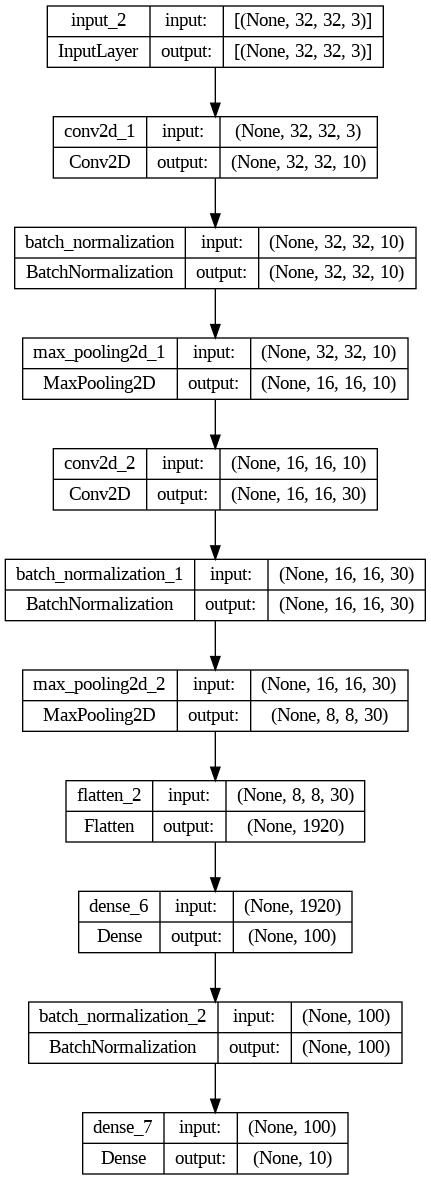

In [ ]:
tf.keras.utils.plot_model(final_model_5, 'final_model_5.png', show_shapes=True)

In [ ]:
# вариант с одним дропаутом
final_model_6 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

     tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_model_6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model_6.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=40, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/40
2500/2500 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.6240

2500/2500 [==============================] - 101s 40ms/step - loss: 1.0753 - accuracy: 0.6240
Epoch 2/40
2500/2500 [==============================] - ETA: 0s - loss: 1.0471 - accuracy: 0.6315

2500/2500 [==============================] - 100s 40ms/step - loss: 1.0471 - accuracy: 0.6315
Epoch 3/40
2499/2500 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.6366

2500/2500 [==============================] - 98s 39ms/step - loss: 1.0385 - accuracy: 0.6366
Epoch 4/40
2500/2500 [==============================] - ETA: 0s - loss: 1.0127 - accuracy: 0.6450

2500/2500 [==============================] - 99s 40ms/step - loss: 1.0127 - accuracy: 0.6450
Epoch 5/40
2500/2500 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.6485

2500/2500 [==============================] - 99s 40ms/step - loss: 1.0037 - accuracy: 0.6485
Epoch 6/40
2500/2500 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.6508

2500/2500 [==============================] - 99s 40ms/step - loss: 1.0000 - accuracy: 0.6508
Epoch 7/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 0.6544

2500/2500 [==============================] - 99s 40ms/step - loss: 0.9860 - accuracy: 0.6544
Epoch 8/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6586

2500/2500 [==============================] - 99s 40ms/step - loss: 0.9789 - accuracy: 0.6586
Epoch 9/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9723 - accuracy: 0.6619

2500/2500 [==============================] - 99s 39ms/step - loss: 0.9723 - accuracy: 0.6619
Epoch 10/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9694 - accuracy: 0.6608

2500/2500 [==============================] - 98s 39ms/step - loss: 0.9694 - accuracy: 0.6608
Epoch 11/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9597 - accuracy: 0.6666

2500/2500 [==============================] - 98s 39ms/step - loss: 0.9597 - accuracy: 0.6666
Epoch 12/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.6711

2500/2500 [==============================] - 100s 40ms/step - loss: 0.9450 - accuracy: 0.6711
Epoch 13/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9410 - accuracy: 0.6709

2500/2500 [==============================] - 98s 39ms/step - loss: 0.9410 - accuracy: 0.6709
Epoch 14/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.9388 - accuracy: 0.6735

2500/2500 [==============================] - 97s 39ms/step - loss: 0.9386 - accuracy: 0.6736
Epoch 15/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9343 - accuracy: 0.6729

2500/2500 [==============================] - 100s 40ms/step - loss: 0.9343 - accuracy: 0.6729
Epoch 16/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.9250 - accuracy: 0.6779

2500/2500 [==============================] - 98s 39ms/step - loss: 0.9251 - accuracy: 0.6778
Epoch 17/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.9287 - accuracy: 0.6746

2500/2500 [==============================] - 98s 39ms/step - loss: 0.9288 - accuracy: 0.6745
Epoch 18/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.9266 - accuracy: 0.6760

2500/2500 [==============================] - 99s 40ms/step - loss: 0.9266 - accuracy: 0.6759
Epoch 19/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9177 - accuracy: 0.6785

2500/2500 [==============================] - 100s 40ms/step - loss: 0.9177 - accuracy: 0.6785
Epoch 20/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9115 - accuracy: 0.6809

2500/2500 [==============================] - 99s 40ms/step - loss: 0.9115 - accuracy: 0.6809
Epoch 21/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.9157 - accuracy: 0.6798

2500/2500 [==============================] - 100s 40ms/step - loss: 0.9159 - accuracy: 0.6797
Epoch 22/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9134 - accuracy: 0.6827

2500/2500 [==============================] - 99s 40ms/step - loss: 0.9134 - accuracy: 0.6827
Epoch 23/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.9135 - accuracy: 0.6823

2500/2500 [==============================] - 99s 40ms/step - loss: 0.9134 - accuracy: 0.6823
Epoch 24/40
2500/2500 [==============================] - ETA: 0s - loss: 0.9089 - accuracy: 0.6831

2500/2500 [==============================] - 101s 40ms/step - loss: 0.9089 - accuracy: 0.6831
Epoch 25/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8990 - accuracy: 0.6872

2500/2500 [==============================] - 99s 39ms/step - loss: 0.8990 - accuracy: 0.6872
Epoch 26/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8949 - accuracy: 0.6868

2500/2500 [==============================] - 97s 39ms/step - loss: 0.8948 - accuracy: 0.6869
Epoch 27/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8868 - accuracy: 0.6908

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8868 - accuracy: 0.6908
Epoch 28/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8992 - accuracy: 0.6854

2500/2500 [==============================] - 100s 40ms/step - loss: 0.8991 - accuracy: 0.6855
Epoch 29/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.6927

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8846 - accuracy: 0.6927
Epoch 30/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8917 - accuracy: 0.6880

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8917 - accuracy: 0.6879
Epoch 31/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.6927

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8804 - accuracy: 0.6927
Epoch 32/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8844 - accuracy: 0.6898

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8843 - accuracy: 0.6898
Epoch 33/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8782 - accuracy: 0.6941

2500/2500 [==============================] - 99s 39ms/step - loss: 0.8782 - accuracy: 0.6941
Epoch 34/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.6932

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8777 - accuracy: 0.6932
Epoch 35/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.6931

2500/2500 [==============================] - 99s 40ms/step - loss: 0.8778 - accuracy: 0.6931
Epoch 36/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.6946

2500/2500 [==============================] - 99s 40ms/step - loss: 0.8749 - accuracy: 0.6946
Epoch 37/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8718 - accuracy: 0.6949

2500/2500 [==============================] - 100s 40ms/step - loss: 0.8718 - accuracy: 0.6949
Epoch 38/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8758 - accuracy: 0.6941

2500/2500 [==============================] - 99s 39ms/step - loss: 0.8757 - accuracy: 0.6941
Epoch 39/40
2499/2500 [============================>.] - ETA: 0s - loss: 0.8688 - accuracy: 0.6969

2500/2500 [==============================] - 100s 40ms/step - loss: 0.8687 - accuracy: 0.6969
Epoch 40/40
2500/2500 [==============================] - ETA: 0s - loss: 0.8679 - accuracy: 0.6973

2500/2500 [==============================] - 98s 39ms/step - loss: 0.8679 - accuracy: 0.6973


In [ ]:
from sklearn.metrics import accuracy_score

predict_x=final_model_6.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 4s 14ms/step

 Test_acc = 0.7014


In [ ]:
final_model_7 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

     tf.keras.layers.Conv2D(filters=30,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_model_7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model_7.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9231 - accuracy: 0.6779

2500/2500 [==============================] - 81s 32ms/step - loss: 0.9231 - accuracy: 0.6779
Epoch 2/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9131 - accuracy: 0.6799

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9131 - accuracy: 0.6799
Epoch 3/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.6802

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9170 - accuracy: 0.6802
Epoch 4/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9213 - accuracy: 0.6784

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9213 - accuracy: 0.6784
Epoch 5/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9078 - accuracy: 0.6823

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9081 - accuracy: 0.6822
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.6819

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9136 - accuracy: 0.6819
Epoch 7/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9065 - accuracy: 0.6811

2500/2500 [==============================] - 82s 33ms/step - loss: 0.9065 - accuracy: 0.6812
Epoch 8/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9090 - accuracy: 0.6836

2500/2500 [==============================] - 81s 33ms/step - loss: 0.9090 - accuracy: 0.6836
Epoch 9/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9010 - accuracy: 0.6838

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9011 - accuracy: 0.6838
Epoch 10/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9009 - accuracy: 0.6846

2500/2500 [==============================] - 82s 33ms/step - loss: 0.9009 - accuracy: 0.6845
Epoch 11/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8965 - accuracy: 0.6870

2500/2500 [==============================] - 80s 32ms/step - loss: 0.8966 - accuracy: 0.6870
Epoch 12/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.6847

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8997 - accuracy: 0.6847
Epoch 13/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8940 - accuracy: 0.6866

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8940 - accuracy: 0.6866
Epoch 14/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8936 - accuracy: 0.6879

2500/2500 [==============================] - 82s 33ms/step - loss: 0.8937 - accuracy: 0.6878
Epoch 15/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8963 - accuracy: 0.6866

2500/2500 [==============================] - 84s 33ms/step - loss: 0.8963 - accuracy: 0.6866
Epoch 16/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.8824 - accuracy: 0.6904

2500/2500 [==============================] - 83s 33ms/step - loss: 0.8824 - accuracy: 0.6904
Epoch 17/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8894 - accuracy: 0.6896

2500/2500 [==============================] - 82s 33ms/step - loss: 0.8894 - accuracy: 0.6896
Epoch 18/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6876

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8867 - accuracy: 0.6876
Epoch 19/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8822 - accuracy: 0.6910

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8820 - accuracy: 0.6910
Epoch 20/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8822 - accuracy: 0.6923

2500/2500 [==============================] - 83s 33ms/step - loss: 0.8821 - accuracy: 0.6923
Epoch 21/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8805 - accuracy: 0.6916

2500/2500 [==============================] - 80s 32ms/step - loss: 0.8805 - accuracy: 0.6916
Epoch 22/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8815 - accuracy: 0.6920

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8813 - accuracy: 0.6920
Epoch 23/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8772 - accuracy: 0.6919

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8773 - accuracy: 0.6918
Epoch 24/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.6958

2500/2500 [==============================] - 80s 32ms/step - loss: 0.8693 - accuracy: 0.6958
Epoch 25/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.6972

2500/2500 [==============================] - 81s 33ms/step - loss: 0.8683 - accuracy: 0.6972
Epoch 26/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8709 - accuracy: 0.6945

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8709 - accuracy: 0.6945
Epoch 27/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8762 - accuracy: 0.6937

2500/2500 [==============================] - 83s 33ms/step - loss: 0.8761 - accuracy: 0.6938
Epoch 28/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.6957

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8693 - accuracy: 0.6957
Epoch 29/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.8769 - accuracy: 0.6934

2500/2500 [==============================] - 81s 32ms/step - loss: 0.8771 - accuracy: 0.6932
Epoch 30/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.8604 - accuracy: 0.6991

2500/2500 [==============================] - 81s 33ms/step - loss: 0.8604 - accuracy: 0.6991
Epoch 31/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.8669 - accuracy: 0.6959

2500/2500 [==============================] - 87s 35ms/step - loss: 0.8670 - accuracy: 0.6959
Epoch 32/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8675 - accuracy: 0.6980

2500/2500 [==============================] - 82s 33ms/step - loss: 0.8676 - accuracy: 0.6980


In [ ]:
from sklearn.metrics import accuracy_score

predict_x=final_model_7.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 5s 17ms/step

 Test_acc = 0.728


In [ ]:
final_model_8 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),

    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

     tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
final_model_8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
final_model_8.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2500/2500 [==============================] - ETA: 0s - loss: 1.6635 - accuracy: 0.3984

2500/2500 [==============================] - 32s 12ms/step - loss: 1.6635 - accuracy: 0.3984
Epoch 2/32
2496/2500 [============================>.] - ETA: 0s - loss: 1.4206 - accuracy: 0.4909

2500/2500 [==============================] - 30s 12ms/step - loss: 1.4204 - accuracy: 0.4908
Epoch 3/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.3273 - accuracy: 0.5265

2500/2500 [==============================] - 29s 12ms/step - loss: 1.3271 - accuracy: 0.5265
Epoch 4/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2569 - accuracy: 0.5562

2500/2500 [==============================] - 30s 12ms/step - loss: 1.2569 - accuracy: 0.5562
Epoch 5/32
2496/2500 [============================>.] - ETA: 0s - loss: 1.2085 - accuracy: 0.5742

2500/2500 [==============================] - 31s 12ms/step - loss: 1.2083 - accuracy: 0.5743
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1681 - accuracy: 0.5856

2500/2500 [==============================] - 30s 12ms/step - loss: 1.1681 - accuracy: 0.5856
Epoch 7/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.1297 - accuracy: 0.6017

2500/2500 [==============================] - 30s 12ms/step - loss: 1.1293 - accuracy: 0.6018
Epoch 8/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.1106 - accuracy: 0.6104

2500/2500 [==============================] - 30s 12ms/step - loss: 1.1106 - accuracy: 0.6104
Epoch 9/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0917 - accuracy: 0.6169

2500/2500 [==============================] - 31s 13ms/step - loss: 1.0917 - accuracy: 0.6169
Epoch 10/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0688 - accuracy: 0.6253

2500/2500 [==============================] - 30s 12ms/step - loss: 1.0689 - accuracy: 0.6252
Epoch 11/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0498 - accuracy: 0.6313

2500/2500 [==============================] - 30s 12ms/step - loss: 1.0498 - accuracy: 0.6313
Epoch 12/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0342 - accuracy: 0.6366

2500/2500 [==============================] - 30s 12ms/step - loss: 1.0343 - accuracy: 0.6367
Epoch 13/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.0223 - accuracy: 0.6392

2500/2500 [==============================] - 31s 12ms/step - loss: 1.0226 - accuracy: 0.6391
Epoch 14/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.0132 - accuracy: 0.6494

2500/2500 [==============================] - 30s 12ms/step - loss: 1.0131 - accuracy: 0.6493
Epoch 15/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9907 - accuracy: 0.6523

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9907 - accuracy: 0.6523
Epoch 16/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.6533

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9869 - accuracy: 0.6532
Epoch 17/32
2496/2500 [============================>.] - ETA: 0s - loss: 0.9814 - accuracy: 0.6576

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9815 - accuracy: 0.6575
Epoch 18/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9697 - accuracy: 0.6632

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9697 - accuracy: 0.6632
Epoch 19/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9542 - accuracy: 0.6634

2500/2500 [==============================] - 31s 13ms/step - loss: 0.9543 - accuracy: 0.6633
Epoch 20/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.9601 - accuracy: 0.6634

2500/2500 [==============================] - 32s 13ms/step - loss: 0.9599 - accuracy: 0.6634
Epoch 21/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9443 - accuracy: 0.6695

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9441 - accuracy: 0.6696
Epoch 22/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.9321 - accuracy: 0.6709

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9321 - accuracy: 0.6708
Epoch 23/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9333 - accuracy: 0.6747

2500/2500 [==============================] - 31s 12ms/step - loss: 0.9333 - accuracy: 0.6747
Epoch 24/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9222 - accuracy: 0.6767

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9222 - accuracy: 0.6767
Epoch 25/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9230 - accuracy: 0.6750

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9232 - accuracy: 0.6749
Epoch 26/32
2496/2500 [============================>.] - ETA: 0s - loss: 0.9124 - accuracy: 0.6804

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9124 - accuracy: 0.6803
Epoch 27/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9123 - accuracy: 0.6838

2500/2500 [==============================] - 31s 12ms/step - loss: 0.9122 - accuracy: 0.6838
Epoch 28/32
2496/2500 [============================>.] - ETA: 0s - loss: 0.9111 - accuracy: 0.6801

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9113 - accuracy: 0.6801
Epoch 29/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9000 - accuracy: 0.6858

2500/2500 [==============================] - 30s 12ms/step - loss: 0.9000 - accuracy: 0.6858
Epoch 30/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.8987 - accuracy: 0.6860

2500/2500 [==============================] - 30s 12ms/step - loss: 0.8989 - accuracy: 0.6859
Epoch 31/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8939 - accuracy: 0.6855

2500/2500 [==============================] - 31s 12ms/step - loss: 0.8939 - accuracy: 0.6855
Epoch 32/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.8879 - accuracy: 0.6888

2500/2500 [==============================] - 30s 12ms/step - loss: 0.8877 - accuracy: 0.6888


In [ ]:
from sklearn.metrics import accuracy_score

predict_x=final_model_8.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 1s 3ms/step

 Test_acc = 0.7261


In [ ]:
# добавить аугментацию и посмотерть болбшие модели(сделать ваариант по ним)

In [ ]:
resnet_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           strides = (2,2)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),

    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),

    tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
resnet_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2500/2500 [==============================] - ETA: 0s - loss: 1.7584 - accuracy: 0.3494

2500/2500 [==============================] - 70s 28ms/step - loss: 1.7584 - accuracy: 0.3494
Epoch 2/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.4666 - accuracy: 0.4698

2500/2500 [==============================] - 70s 28ms/step - loss: 1.4666 - accuracy: 0.4698
Epoch 3/32
2500/2500 [==============================] - ETA: 0s - loss: 1.3447 - accuracy: 0.5184

2500/2500 [==============================] - 68s 27ms/step - loss: 1.3447 - accuracy: 0.5184
Epoch 4/32
2500/2500 [==============================] - ETA: 0s - loss: 1.2643 - accuracy: 0.5494

2500/2500 [==============================] - 69s 28ms/step - loss: 1.2643 - accuracy: 0.5494
Epoch 5/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.2021 - accuracy: 0.5693

2500/2500 [==============================] - 69s 28ms/step - loss: 1.2023 - accuracy: 0.5693
Epoch 6/32
2500/2500 [==============================] - ETA: 0s - loss: 1.1566 - accuracy: 0.5909

2500/2500 [==============================] - 69s 28ms/step - loss: 1.1566 - accuracy: 0.5909
Epoch 7/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.1134 - accuracy: 0.6045

2500/2500 [==============================] - 68s 27ms/step - loss: 1.1134 - accuracy: 0.6044
Epoch 8/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.6209

2500/2500 [==============================] - 69s 27ms/step - loss: 1.0780 - accuracy: 0.6209
Epoch 9/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0550 - accuracy: 0.6273

2500/2500 [==============================] - 69s 27ms/step - loss: 1.0551 - accuracy: 0.6273
Epoch 10/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.0264 - accuracy: 0.6372

2500/2500 [==============================] - 68s 27ms/step - loss: 1.0264 - accuracy: 0.6371
Epoch 11/32
2500/2500 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.6443

2500/2500 [==============================] - 69s 28ms/step - loss: 1.0081 - accuracy: 0.6443
Epoch 12/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9910 - accuracy: 0.6536

2500/2500 [==============================] - 69s 27ms/step - loss: 0.9910 - accuracy: 0.6536
Epoch 13/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.9770 - accuracy: 0.6578

2500/2500 [==============================] - 69s 27ms/step - loss: 0.9773 - accuracy: 0.6578
Epoch 14/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9610 - accuracy: 0.6646

2500/2500 [==============================] - 69s 28ms/step - loss: 0.9610 - accuracy: 0.6646
Epoch 15/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.9424 - accuracy: 0.6745

2500/2500 [==============================] - 69s 28ms/step - loss: 0.9425 - accuracy: 0.6745
Epoch 16/32
2500/2500 [==============================] - ETA: 0s - loss: 0.9263 - accuracy: 0.6752

2500/2500 [==============================] - 69s 27ms/step - loss: 0.9263 - accuracy: 0.6752
Epoch 17/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.9184 - accuracy: 0.6790

2500/2500 [==============================] - 69s 28ms/step - loss: 0.9185 - accuracy: 0.6790
Epoch 18/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.9058 - accuracy: 0.6848

2500/2500 [==============================] - 70s 28ms/step - loss: 0.9058 - accuracy: 0.6848
Epoch 19/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8976 - accuracy: 0.6865

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8976 - accuracy: 0.6865
Epoch 20/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.6927

2500/2500 [==============================] - 70s 28ms/step - loss: 0.8873 - accuracy: 0.6927
Epoch 21/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.8776 - accuracy: 0.6905

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8780 - accuracy: 0.6903
Epoch 22/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8653 - accuracy: 0.7011

2500/2500 [==============================] - 69s 27ms/step - loss: 0.8653 - accuracy: 0.7011
Epoch 23/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8571 - accuracy: 0.7033

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8573 - accuracy: 0.7032
Epoch 24/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.7022

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8513 - accuracy: 0.7022
Epoch 25/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8391 - accuracy: 0.7102

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8392 - accuracy: 0.7103
Epoch 26/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.8379 - accuracy: 0.7111

2500/2500 [==============================] - 71s 28ms/step - loss: 0.8379 - accuracy: 0.7111
Epoch 27/32
2497/2500 [============================>.] - ETA: 0s - loss: 0.8356 - accuracy: 0.7077

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8355 - accuracy: 0.7078
Epoch 28/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.7143

2500/2500 [==============================] - 70s 28ms/step - loss: 0.8231 - accuracy: 0.7143
Epoch 29/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8179 - accuracy: 0.7153

2500/2500 [==============================] - 70s 28ms/step - loss: 0.8177 - accuracy: 0.7154
Epoch 30/32
2500/2500 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.7189

2500/2500 [==============================] - 70s 28ms/step - loss: 0.8159 - accuracy: 0.7189
Epoch 31/32
2498/2500 [============================>.] - ETA: 0s - loss: 0.8150 - accuracy: 0.7173

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8148 - accuracy: 0.7173
Epoch 32/32
2499/2500 [============================>.] - ETA: 0s - loss: 0.8121 - accuracy: 0.7193

2500/2500 [==============================] - 70s 28ms/step - loss: 0.8120 - accuracy: 0.7193


In [ ]:
from sklearn.metrics import accuracy_score

predict_x=resnet_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 3s 10ms/step

 Test_acc = 0.7252


In [ ]:
resnet_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           strides = (2,2)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),

    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),

    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
resnet_model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_model_2.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=70, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

predict_x=resnet_model_2.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

Epoch 1/70
2499/2500 [============================>.] - ETA: 0s - loss: 1.6534 - accuracy: 0.3996

2500/2500 [==============================] - 81s 32ms/step - loss: 1.6532 - accuracy: 0.3996
Epoch 2/70
2500/2500 [==============================] - ETA: 0s - loss: 1.3857 - accuracy: 0.5015

2500/2500 [==============================] - 79s 31ms/step - loss: 1.3857 - accuracy: 0.5015
Epoch 3/70
2500/2500 [==============================] - ETA: 0s - loss: 1.2706 - accuracy: 0.5459

2500/2500 [==============================] - 79s 31ms/step - loss: 1.2706 - accuracy: 0.5459
Epoch 4/70
2499/2500 [============================>.] - ETA: 0s - loss: 1.2133 - accuracy: 0.5676

2500/2500 [==============================] - 78s 31ms/step - loss: 1.2134 - accuracy: 0.5676
Epoch 5/70
2498/2500 [============================>.] - ETA: 0s - loss: 1.1578 - accuracy: 0.5896

2500/2500 [==============================] - 77s 31ms/step - loss: 1.1578 - accuracy: 0.5897
Epoch 6/70
2499/2500 [============================>.] - ETA: 0s - loss: 1.1219 - accuracy: 0.6043

2500/2500 [==============================] - 78s 31ms/step - loss: 1.1217 - accuracy: 0.6043
Epoch 7/70
2500/2500 [==============================] - ETA: 0s - loss: 1.0811 - accuracy: 0.6187

2500/2500 [==============================] - 77s 31ms/step - loss: 1.0811 - accuracy: 0.6187
Epoch 8/70
2498/2500 [============================>.] - ETA: 0s - loss: 1.0450 - accuracy: 0.6311

2500/2500 [==============================] - 77s 31ms/step - loss: 1.0451 - accuracy: 0.6310
Epoch 9/70
2500/2500 [==============================] - ETA: 0s - loss: 1.0201 - accuracy: 0.6406

2500/2500 [==============================] - 77s 31ms/step - loss: 1.0201 - accuracy: 0.6406
Epoch 10/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.6493

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9986 - accuracy: 0.6493
Epoch 11/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9825 - accuracy: 0.6574

2500/2500 [==============================] - 80s 32ms/step - loss: 0.9825 - accuracy: 0.6574
Epoch 12/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.6606

2500/2500 [==============================] - 77s 31ms/step - loss: 0.9623 - accuracy: 0.6606
Epoch 13/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.9433 - accuracy: 0.6706

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9435 - accuracy: 0.6706
Epoch 14/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9312 - accuracy: 0.6737

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9312 - accuracy: 0.6737
Epoch 15/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.9198 - accuracy: 0.6780

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9199 - accuracy: 0.6780
Epoch 16/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.9079 - accuracy: 0.6827

2500/2500 [==============================] - 79s 31ms/step - loss: 0.9080 - accuracy: 0.6827
Epoch 17/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.8895 - accuracy: 0.6905

2500/2500 [==============================] - 77s 31ms/step - loss: 0.8895 - accuracy: 0.6905
Epoch 18/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6904

2500/2500 [==============================] - 77s 31ms/step - loss: 0.8867 - accuracy: 0.6904
Epoch 19/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8753 - accuracy: 0.6939

2500/2500 [==============================] - 80s 32ms/step - loss: 0.8753 - accuracy: 0.6939
Epoch 20/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8623 - accuracy: 0.6974

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8623 - accuracy: 0.6974
Epoch 21/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.8566 - accuracy: 0.7036

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8564 - accuracy: 0.7037
Epoch 22/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.7035

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8464 - accuracy: 0.7035
Epoch 23/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.8446 - accuracy: 0.7065

2500/2500 [==============================] - 79s 31ms/step - loss: 0.8447 - accuracy: 0.7064
Epoch 24/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.8311 - accuracy: 0.7068

2500/2500 [==============================] - 77s 31ms/step - loss: 0.8310 - accuracy: 0.7068
Epoch 25/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.7114

2500/2500 [==============================] - 76s 31ms/step - loss: 0.8260 - accuracy: 0.7114
Epoch 26/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.7123

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8228 - accuracy: 0.7123
Epoch 27/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8124 - accuracy: 0.7174

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8124 - accuracy: 0.7174
Epoch 28/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.8044 - accuracy: 0.7204

2500/2500 [==============================] - 79s 32ms/step - loss: 0.8045 - accuracy: 0.7204
Epoch 29/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.7240

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7969 - accuracy: 0.7240
Epoch 30/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7949 - accuracy: 0.7231

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7948 - accuracy: 0.7232
Epoch 31/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7881 - accuracy: 0.7269

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7881 - accuracy: 0.7269
Epoch 32/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7883 - accuracy: 0.7236

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7883 - accuracy: 0.7236
Epoch 33/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7801 - accuracy: 0.7273

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7800 - accuracy: 0.7273
Epoch 34/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7807 - accuracy: 0.7275

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7808 - accuracy: 0.7276
Epoch 35/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.7316

2500/2500 [==============================] - 82s 33ms/step - loss: 0.7716 - accuracy: 0.7316
Epoch 36/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7693 - accuracy: 0.7322

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7693 - accuracy: 0.7322
Epoch 37/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7640 - accuracy: 0.7350

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7639 - accuracy: 0.7350
Epoch 38/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7549 - accuracy: 0.7371

2500/2500 [==============================] - 79s 31ms/step - loss: 0.7549 - accuracy: 0.7371
Epoch 39/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7645 - accuracy: 0.7357

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7648 - accuracy: 0.7356
Epoch 40/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7449 - accuracy: 0.7422

2500/2500 [==============================] - 81s 33ms/step - loss: 0.7448 - accuracy: 0.7422
Epoch 41/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7486 - accuracy: 0.7393

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7485 - accuracy: 0.7394
Epoch 42/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7507 - accuracy: 0.7385

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7506 - accuracy: 0.7386
Epoch 43/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7402 - accuracy: 0.7402

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7402 - accuracy: 0.7402
Epoch 44/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.7427

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7424 - accuracy: 0.7427
Epoch 45/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.7447

2500/2500 [==============================] - 81s 32ms/step - loss: 0.7346 - accuracy: 0.7447
Epoch 46/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7334 - accuracy: 0.7451

2500/2500 [==============================] - 81s 33ms/step - loss: 0.7335 - accuracy: 0.7451
Epoch 47/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7262 - accuracy: 0.7472

2500/2500 [==============================] - 83s 33ms/step - loss: 0.7261 - accuracy: 0.7473
Epoch 48/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7231 - accuracy: 0.7470

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7231 - accuracy: 0.7470
Epoch 49/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7228 - accuracy: 0.7482

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7228 - accuracy: 0.7483
Epoch 50/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.7487

2500/2500 [==============================] - 83s 33ms/step - loss: 0.7218 - accuracy: 0.7487
Epoch 51/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7177 - accuracy: 0.7520

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7177 - accuracy: 0.7520
Epoch 52/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.7501

2500/2500 [==============================] - 82s 33ms/step - loss: 0.7214 - accuracy: 0.7501
Epoch 53/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.7492

2500/2500 [==============================] - 74s 30ms/step - loss: 0.7154 - accuracy: 0.7492
Epoch 54/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7503

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7137 - accuracy: 0.7503
Epoch 55/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7084 - accuracy: 0.7525

2500/2500 [==============================] - 75s 30ms/step - loss: 0.7084 - accuracy: 0.7525
Epoch 56/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7538

2500/2500 [==============================] - 75s 30ms/step - loss: 0.7090 - accuracy: 0.7538
Epoch 57/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.7519

2500/2500 [==============================] - 79s 31ms/step - loss: 0.7060 - accuracy: 0.7519
Epoch 58/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7055 - accuracy: 0.7539

2500/2500 [==============================] - 75s 30ms/step - loss: 0.7057 - accuracy: 0.7539
Epoch 59/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6982 - accuracy: 0.7566

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6982 - accuracy: 0.7566
Epoch 60/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6997 - accuracy: 0.7555

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6996 - accuracy: 0.7555
Epoch 61/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6950 - accuracy: 0.7596

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6951 - accuracy: 0.7595
Epoch 62/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.7589

2500/2500 [==============================] - 77s 31ms/step - loss: 0.6936 - accuracy: 0.7589
Epoch 63/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.7579

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6917 - accuracy: 0.7579
Epoch 64/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.7629

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6859 - accuracy: 0.7629
Epoch 65/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.7585

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6890 - accuracy: 0.7585
Epoch 66/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.7602

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6891 - accuracy: 0.7602
Epoch 67/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.7612

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6868 - accuracy: 0.7612
Epoch 68/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.7656

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6763 - accuracy: 0.7656
Epoch 69/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6802 - accuracy: 0.7651

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6802 - accuracy: 0.7651
Epoch 70/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.7620

313/313 [==============================] - 3s 10ms/step

 Test_acc = 0.762


In [ ]:
resnet_model_3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           strides = (2,2)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=32,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),

    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
resnet_model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
resnet_model_3.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=70, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

predict_x=resnet_model_3.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

Epoch 1/70
2499/2500 [============================>.] - ETA: 0s - loss: 1.6393 - accuracy: 0.4096

2500/2500 [==============================] - 83s 32ms/step - loss: 1.6391 - accuracy: 0.4097
Epoch 2/70
2500/2500 [==============================] - ETA: 0s - loss: 1.3603 - accuracy: 0.5132

2500/2500 [==============================] - 78s 31ms/step - loss: 1.3603 - accuracy: 0.5132
Epoch 3/70
2498/2500 [============================>.] - ETA: 0s - loss: 1.2333 - accuracy: 0.5608

2500/2500 [==============================] - 85s 34ms/step - loss: 1.2333 - accuracy: 0.5608
Epoch 4/70
2498/2500 [============================>.] - ETA: 0s - loss: 1.1554 - accuracy: 0.5908

2500/2500 [==============================] - 77s 31ms/step - loss: 1.1556 - accuracy: 0.5907
Epoch 5/70
2499/2500 [============================>.] - ETA: 0s - loss: 1.0973 - accuracy: 0.6151

2500/2500 [==============================] - 80s 32ms/step - loss: 1.0974 - accuracy: 0.6150
Epoch 6/70
2500/2500 [==============================] - ETA: 0s - loss: 1.0467 - accuracy: 0.6341

2500/2500 [==============================] - 77s 31ms/step - loss: 1.0467 - accuracy: 0.6341
Epoch 7/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9917 - accuracy: 0.6560

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9917 - accuracy: 0.6560
Epoch 8/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.6609

2500/2500 [==============================] - 78s 31ms/step - loss: 0.9742 - accuracy: 0.6609
Epoch 9/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.9387 - accuracy: 0.6752

2500/2500 [==============================] - 77s 31ms/step - loss: 0.9387 - accuracy: 0.6753
Epoch 10/70
2500/2500 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.6816

2500/2500 [==============================] - 81s 32ms/step - loss: 0.9200 - accuracy: 0.6816
Epoch 11/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.8984 - accuracy: 0.6881

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8983 - accuracy: 0.6881
Epoch 12/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.6916

2500/2500 [==============================] - 79s 32ms/step - loss: 0.8795 - accuracy: 0.6916
Epoch 13/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.8594 - accuracy: 0.7028

2500/2500 [==============================] - 79s 32ms/step - loss: 0.8594 - accuracy: 0.7028
Epoch 14/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.8560 - accuracy: 0.7038

2500/2500 [==============================] - 77s 31ms/step - loss: 0.8560 - accuracy: 0.7038
Epoch 15/70
2500/2500 [==============================] - ETA: 0s - loss: 0.8339 - accuracy: 0.7107

2500/2500 [==============================] - 79s 32ms/step - loss: 0.8339 - accuracy: 0.7107
Epoch 16/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.7134

2500/2500 [==============================] - 77s 31ms/step - loss: 0.8244 - accuracy: 0.7134
Epoch 17/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.8149 - accuracy: 0.7170

2500/2500 [==============================] - 78s 31ms/step - loss: 0.8148 - accuracy: 0.7171
Epoch 18/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7981 - accuracy: 0.7218

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7981 - accuracy: 0.7218
Epoch 19/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7862 - accuracy: 0.7282

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7864 - accuracy: 0.7282
Epoch 20/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7781 - accuracy: 0.7327

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7781 - accuracy: 0.7327
Epoch 21/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.7313

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7759 - accuracy: 0.7313
Epoch 22/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.7336

2500/2500 [==============================] - 77s 31ms/step - loss: 0.7631 - accuracy: 0.7337
Epoch 23/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.7343

2500/2500 [==============================] - 81s 32ms/step - loss: 0.7554 - accuracy: 0.7343
Epoch 24/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.7406

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7480 - accuracy: 0.7406
Epoch 25/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7426 - accuracy: 0.7431

2500/2500 [==============================] - 76s 31ms/step - loss: 0.7426 - accuracy: 0.7431
Epoch 26/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.7469

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7336 - accuracy: 0.7469
Epoch 27/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7258 - accuracy: 0.7480

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7258 - accuracy: 0.7480
Epoch 28/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7229 - accuracy: 0.7505

2500/2500 [==============================] - 78s 31ms/step - loss: 0.7228 - accuracy: 0.7505
Epoch 29/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7137 - accuracy: 0.7521

2500/2500 [==============================] - 79s 32ms/step - loss: 0.7135 - accuracy: 0.7521
Epoch 30/70
2500/2500 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7523

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7116 - accuracy: 0.7523
Epoch 31/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.7058 - accuracy: 0.7569

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7059 - accuracy: 0.7570
Epoch 32/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.7025 - accuracy: 0.7591

2500/2500 [==============================] - 80s 32ms/step - loss: 0.7024 - accuracy: 0.7592
Epoch 33/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6903 - accuracy: 0.7605

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6903 - accuracy: 0.7604
Epoch 34/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.7613

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6878 - accuracy: 0.7614
Epoch 35/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.7619

2500/2500 [==============================] - 81s 32ms/step - loss: 0.6848 - accuracy: 0.7619
Epoch 36/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.7635

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6838 - accuracy: 0.7635
Epoch 37/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.7640

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6808 - accuracy: 0.7640
Epoch 38/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.7673

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6765 - accuracy: 0.7673
Epoch 39/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.7655

2500/2500 [==============================] - 82s 33ms/step - loss: 0.6727 - accuracy: 0.7654
Epoch 40/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6658 - accuracy: 0.7692

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6660 - accuracy: 0.7691
Epoch 41/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.7699

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6574 - accuracy: 0.7699
Epoch 42/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.7711

2500/2500 [==============================] - 82s 33ms/step - loss: 0.6611 - accuracy: 0.7711
Epoch 43/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.7699

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6626 - accuracy: 0.7699
Epoch 44/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6458 - accuracy: 0.7745

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6461 - accuracy: 0.7744
Epoch 45/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6475 - accuracy: 0.7760

2500/2500 [==============================] - 81s 32ms/step - loss: 0.6479 - accuracy: 0.7758
Epoch 46/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.7788

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6456 - accuracy: 0.7788
Epoch 47/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.7736

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6513 - accuracy: 0.7736
Epoch 48/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7786

2500/2500 [==============================] - 82s 33ms/step - loss: 0.6405 - accuracy: 0.7786
Epoch 49/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6394 - accuracy: 0.7786

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6393 - accuracy: 0.7786
Epoch 50/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6353 - accuracy: 0.7807

2500/2500 [==============================] - 81s 32ms/step - loss: 0.6352 - accuracy: 0.7807
Epoch 51/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6396 - accuracy: 0.7804

2500/2500 [==============================] - 81s 32ms/step - loss: 0.6396 - accuracy: 0.7804
Epoch 52/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6325 - accuracy: 0.7806

2500/2500 [==============================] - 77s 31ms/step - loss: 0.6325 - accuracy: 0.7805
Epoch 53/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7813

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6271 - accuracy: 0.7813
Epoch 54/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6330 - accuracy: 0.7815

2500/2500 [==============================] - 77s 31ms/step - loss: 0.6334 - accuracy: 0.7814
Epoch 55/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6256 - accuracy: 0.7818

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6255 - accuracy: 0.7818
Epoch 56/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.7828

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6203 - accuracy: 0.7827
Epoch 57/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.7836

2500/2500 [==============================] - 82s 33ms/step - loss: 0.6200 - accuracy: 0.7836
Epoch 58/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.7862

2500/2500 [==============================] - 77s 31ms/step - loss: 0.6173 - accuracy: 0.7862
Epoch 59/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6142 - accuracy: 0.7875

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6143 - accuracy: 0.7875
Epoch 60/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.7877

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6155 - accuracy: 0.7877
Epoch 61/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.7909

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6078 - accuracy: 0.7909
Epoch 62/70
2500/2500 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.7909

2500/2500 [==============================] - 79s 32ms/step - loss: 0.6061 - accuracy: 0.7909
Epoch 63/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6125 - accuracy: 0.7877

2500/2500 [==============================] - 82s 33ms/step - loss: 0.6124 - accuracy: 0.7878
Epoch 64/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6051 - accuracy: 0.7879

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6051 - accuracy: 0.7879
Epoch 65/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6030 - accuracy: 0.7934

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6030 - accuracy: 0.7934
Epoch 66/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.7886

2500/2500 [==============================] - 80s 32ms/step - loss: 0.6041 - accuracy: 0.7886
Epoch 67/70
2498/2500 [============================>.] - ETA: 0s - loss: 0.6063 - accuracy: 0.7881

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6063 - accuracy: 0.7881
Epoch 68/70
2500/2500 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.7923

2500/2500 [==============================] - 82s 33ms/step - loss: 0.5945 - accuracy: 0.7923
Epoch 69/70
2500/2500 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.7934

2500/2500 [==============================] - 78s 31ms/step - loss: 0.5969 - accuracy: 0.7934
Epoch 70/70
2499/2500 [============================>.] - ETA: 0s - loss: 0.5961 - accuracy: 0.7922

313/313 [==============================] - 4s 12ms/step

 Test_acc = 0.7748


In [ ]:
resnet_model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
                         metrics=['accuracy'])
resnet_model_3.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=100, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

predict_x=resnet_model_3.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
  print("Это победа!")

Epoch 1/100
2500/2500 [==============================] - ETA: 0s - loss: 1.6414 - accuracy: 0.4029

2500/2500 [==============================] - 110s 42ms/step - loss: 1.6414 - accuracy: 0.4029
Epoch 2/100
2498/2500 [============================>.] - ETA: 0s - loss: 1.3522 - accuracy: 0.5131

2500/2500 [==============================] - 99s 40ms/step - loss: 1.3519 - accuracy: 0.5132
Epoch 3/100
2500/2500 [==============================] - ETA: 0s - loss: 1.2293 - accuracy: 0.5631

2500/2500 [==============================] - 73s 29ms/step - loss: 1.2293 - accuracy: 0.5631
Epoch 4/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.1501 - accuracy: 0.5932

2500/2500 [==============================] - 83s 33ms/step - loss: 1.1501 - accuracy: 0.5932
Epoch 5/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.0790 - accuracy: 0.6183

2500/2500 [==============================] - 79s 32ms/step - loss: 1.0789 - accuracy: 0.6183
Epoch 6/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.6392

2500/2500 [==============================] - 75s 30ms/step - loss: 1.0377 - accuracy: 0.6391
Epoch 7/100
2500/2500 [==============================] - ETA: 0s - loss: 0.9895 - accuracy: 0.6551

2500/2500 [==============================] - 71s 29ms/step - loss: 0.9895 - accuracy: 0.6551
Epoch 8/100
2500/2500 [==============================] - ETA: 0s - loss: 0.9618 - accuracy: 0.6655

2500/2500 [==============================] - 73s 29ms/step - loss: 0.9618 - accuracy: 0.6655
Epoch 9/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.9351 - accuracy: 0.6736

2500/2500 [==============================] - 72s 29ms/step - loss: 0.9352 - accuracy: 0.6736
Epoch 10/100
2500/2500 [==============================] - ETA: 0s - loss: 0.9121 - accuracy: 0.6815

2500/2500 [==============================] - 77s 31ms/step - loss: 0.9121 - accuracy: 0.6815
Epoch 11/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.8970 - accuracy: 0.6877

2500/2500 [==============================] - 70s 28ms/step - loss: 0.8969 - accuracy: 0.6877
Epoch 12/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.8675 - accuracy: 0.6972

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8677 - accuracy: 0.6972
Epoch 13/100
2500/2500 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.7036

2500/2500 [==============================] - 68s 27ms/step - loss: 0.8487 - accuracy: 0.7036
Epoch 14/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.8452 - accuracy: 0.7077

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8452 - accuracy: 0.7077
Epoch 15/100
2500/2500 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.7127

2500/2500 [==============================] - 68s 27ms/step - loss: 0.8279 - accuracy: 0.7127
Epoch 16/100
2500/2500 [==============================] - ETA: 0s - loss: 0.8138 - accuracy: 0.7154

2500/2500 [==============================] - 69s 27ms/step - loss: 0.8138 - accuracy: 0.7154
Epoch 17/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.8014 - accuracy: 0.7214

2500/2500 [==============================] - 69s 28ms/step - loss: 0.8013 - accuracy: 0.7214
Epoch 18/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.7983 - accuracy: 0.7217

2500/2500 [==============================] - 73s 29ms/step - loss: 0.7982 - accuracy: 0.7217
Epoch 19/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.7861 - accuracy: 0.7278

2500/2500 [==============================] - 71s 28ms/step - loss: 0.7861 - accuracy: 0.7279
Epoch 20/100
2500/2500 [==============================] - ETA: 0s - loss: 0.7691 - accuracy: 0.7336

2500/2500 [==============================] - 68s 27ms/step - loss: 0.7691 - accuracy: 0.7336
Epoch 21/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.7681 - accuracy: 0.7345

2500/2500 [==============================] - 68s 27ms/step - loss: 0.7683 - accuracy: 0.7344
Epoch 22/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.7556 - accuracy: 0.7376

2500/2500 [==============================] - 71s 28ms/step - loss: 0.7556 - accuracy: 0.7376
Epoch 23/100
2500/2500 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.7416

2500/2500 [==============================] - 70s 28ms/step - loss: 0.7497 - accuracy: 0.7416
Epoch 24/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.7423 - accuracy: 0.7423

2500/2500 [==============================] - 69s 28ms/step - loss: 0.7423 - accuracy: 0.7423
Epoch 25/100
2500/2500 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.7442

2500/2500 [==============================] - 70s 28ms/step - loss: 0.7342 - accuracy: 0.7442
Epoch 26/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.7304 - accuracy: 0.7466

2500/2500 [==============================] - 73s 29ms/step - loss: 0.7303 - accuracy: 0.7466
Epoch 27/100
2500/2500 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7468

2500/2500 [==============================] - 69s 28ms/step - loss: 0.7291 - accuracy: 0.7468
Epoch 28/100
2500/2500 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7527

2500/2500 [==============================] - 70s 28ms/step - loss: 0.7177 - accuracy: 0.7527
Epoch 29/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.7098 - accuracy: 0.7551

2500/2500 [==============================] - 74s 29ms/step - loss: 0.7097 - accuracy: 0.7551
Epoch 30/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.7050 - accuracy: 0.7547

2500/2500 [==============================] - 73s 29ms/step - loss: 0.7051 - accuracy: 0.7547
Epoch 31/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.7011 - accuracy: 0.7552

2500/2500 [==============================] - 73s 29ms/step - loss: 0.7010 - accuracy: 0.7552
Epoch 32/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7589

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6931 - accuracy: 0.7589
Epoch 33/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.7636

2500/2500 [==============================] - 77s 31ms/step - loss: 0.6867 - accuracy: 0.7636
Epoch 34/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6912 - accuracy: 0.7628

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6910 - accuracy: 0.7628
Epoch 35/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6850 - accuracy: 0.7605

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6850 - accuracy: 0.7605
Epoch 36/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.7678

2500/2500 [==============================] - 72s 29ms/step - loss: 0.6799 - accuracy: 0.7678
Epoch 37/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.7682

2500/2500 [==============================] - 74s 29ms/step - loss: 0.6751 - accuracy: 0.7683
Epoch 38/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.7653

2500/2500 [==============================] - 73s 29ms/step - loss: 0.6806 - accuracy: 0.7653
Epoch 39/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6640 - accuracy: 0.7694

2500/2500 [==============================] - 72s 29ms/step - loss: 0.6642 - accuracy: 0.7693
Epoch 40/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6630 - accuracy: 0.7700

2500/2500 [==============================] - 72s 29ms/step - loss: 0.6631 - accuracy: 0.7700
Epoch 41/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.7697

2500/2500 [==============================] - 70s 28ms/step - loss: 0.6624 - accuracy: 0.7697
Epoch 42/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6588 - accuracy: 0.7709

2500/2500 [==============================] - 72s 29ms/step - loss: 0.6588 - accuracy: 0.7709
Epoch 43/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.7738

2500/2500 [==============================] - 69s 28ms/step - loss: 0.6562 - accuracy: 0.7738
Epoch 44/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7751

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6506 - accuracy: 0.7751
Epoch 45/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.7761

2500/2500 [==============================] - 71s 28ms/step - loss: 0.6438 - accuracy: 0.7761
Epoch 46/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6347 - accuracy: 0.7797

2500/2500 [==============================] - 73s 29ms/step - loss: 0.6348 - accuracy: 0.7796
Epoch 47/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.7788

2500/2500 [==============================] - 73s 29ms/step - loss: 0.6380 - accuracy: 0.7788
Epoch 48/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6373 - accuracy: 0.7788

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6374 - accuracy: 0.7788
Epoch 49/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6367 - accuracy: 0.7795

2500/2500 [==============================] - 72s 29ms/step - loss: 0.6367 - accuracy: 0.7795
Epoch 50/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.7831

2500/2500 [==============================] - 73s 29ms/step - loss: 0.6295 - accuracy: 0.7831
Epoch 51/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.7815

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6289 - accuracy: 0.7815
Epoch 52/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6296 - accuracy: 0.7828

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6296 - accuracy: 0.7828
Epoch 53/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.7842

2500/2500 [==============================] - 70s 28ms/step - loss: 0.6206 - accuracy: 0.7841
Epoch 54/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6237 - accuracy: 0.7833

2500/2500 [==============================] - 74s 30ms/step - loss: 0.6238 - accuracy: 0.7833
Epoch 55/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.7847

2500/2500 [==============================] - 77s 31ms/step - loss: 0.6166 - accuracy: 0.7847
Epoch 56/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6189 - accuracy: 0.7867

2500/2500 [==============================] - 74s 29ms/step - loss: 0.6188 - accuracy: 0.7867
Epoch 57/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6192 - accuracy: 0.7858

2500/2500 [==============================] - 76s 30ms/step - loss: 0.6191 - accuracy: 0.7858
Epoch 58/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.6135 - accuracy: 0.7862

2500/2500 [==============================] - 74s 30ms/step - loss: 0.6134 - accuracy: 0.7863
Epoch 59/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7889

2500/2500 [==============================] - 78s 31ms/step - loss: 0.6128 - accuracy: 0.7889
Epoch 60/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6069 - accuracy: 0.7888

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6069 - accuracy: 0.7888
Epoch 61/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.7869

2500/2500 [==============================] - 72s 29ms/step - loss: 0.6112 - accuracy: 0.7869
Epoch 62/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.6084 - accuracy: 0.7879

2500/2500 [==============================] - 75s 30ms/step - loss: 0.6086 - accuracy: 0.7878
Epoch 63/100
2500/2500 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7916

2500/2500 [==============================] - 74s 30ms/step - loss: 0.6001 - accuracy: 0.7916
Epoch 64/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.7947

2500/2500 [==============================] - 71s 28ms/step - loss: 0.5959 - accuracy: 0.7947
Epoch 65/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5977 - accuracy: 0.7938

2500/2500 [==============================] - 72s 29ms/step - loss: 0.5977 - accuracy: 0.7938
Epoch 66/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.7937

2500/2500 [==============================] - 74s 30ms/step - loss: 0.5994 - accuracy: 0.7937
Epoch 67/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5975 - accuracy: 0.7953

2500/2500 [==============================] - 74s 29ms/step - loss: 0.5976 - accuracy: 0.7953
Epoch 68/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5962 - accuracy: 0.7912

2500/2500 [==============================] - 71s 28ms/step - loss: 0.5964 - accuracy: 0.7911
Epoch 69/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.7961

2500/2500 [==============================] - 70s 28ms/step - loss: 0.5885 - accuracy: 0.7961
Epoch 70/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.7968

2500/2500 [==============================] - 71s 29ms/step - loss: 0.5892 - accuracy: 0.7968
Epoch 71/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5872 - accuracy: 0.7956

2500/2500 [==============================] - 72s 29ms/step - loss: 0.5873 - accuracy: 0.7957
Epoch 72/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7973

2500/2500 [==============================] - 72s 29ms/step - loss: 0.5843 - accuracy: 0.7973
Epoch 73/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.7964

2500/2500 [==============================] - 78s 31ms/step - loss: 0.5865 - accuracy: 0.7964
Epoch 74/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.7951

2500/2500 [==============================] - 73s 29ms/step - loss: 0.5875 - accuracy: 0.7951
Epoch 75/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5795 - accuracy: 0.7984

2500/2500 [==============================] - 71s 28ms/step - loss: 0.5795 - accuracy: 0.7984
Epoch 76/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7983

2500/2500 [==============================] - 72s 29ms/step - loss: 0.5782 - accuracy: 0.7983
Epoch 77/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5784 - accuracy: 0.7991

2500/2500 [==============================] - 73s 29ms/step - loss: 0.5782 - accuracy: 0.7992
Epoch 78/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.8004

2500/2500 [==============================] - 73s 29ms/step - loss: 0.5720 - accuracy: 0.8004
Epoch 79/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5719 - accuracy: 0.8030

2500/2500 [==============================] - 75s 30ms/step - loss: 0.5719 - accuracy: 0.8030
Epoch 80/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5685 - accuracy: 0.8025

2500/2500 [==============================] - 76s 30ms/step - loss: 0.5684 - accuracy: 0.8026
Epoch 81/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.8011

2500/2500 [==============================] - 79s 31ms/step - loss: 0.5759 - accuracy: 0.8011
Epoch 82/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5715 - accuracy: 0.8020

2500/2500 [==============================] - 78s 31ms/step - loss: 0.5714 - accuracy: 0.8020
Epoch 83/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5732 - accuracy: 0.8025

2500/2500 [==============================] - 75s 30ms/step - loss: 0.5732 - accuracy: 0.8025
Epoch 84/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5731 - accuracy: 0.8025

2500/2500 [==============================] - 77s 31ms/step - loss: 0.5731 - accuracy: 0.8025
Epoch 85/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.8017

2500/2500 [==============================] - 74s 30ms/step - loss: 0.5659 - accuracy: 0.8017
Epoch 86/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5708 - accuracy: 0.8018

2500/2500 [==============================] - 75s 30ms/step - loss: 0.5708 - accuracy: 0.8018
Epoch 87/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.8042

2500/2500 [==============================] - 75s 30ms/step - loss: 0.5633 - accuracy: 0.8042
Epoch 88/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5624 - accuracy: 0.8026

2500/2500 [==============================] - 74s 30ms/step - loss: 0.5623 - accuracy: 0.8026
Epoch 89/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5598 - accuracy: 0.8042

2500/2500 [==============================] - 76s 30ms/step - loss: 0.5599 - accuracy: 0.8041
Epoch 90/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.8025

2500/2500 [==============================] - 73s 29ms/step - loss: 0.5646 - accuracy: 0.8025
Epoch 91/100
2497/2500 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.8075

2500/2500 [==============================] - 72s 29ms/step - loss: 0.5536 - accuracy: 0.8075
Epoch 92/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.8068

2500/2500 [==============================] - 69s 28ms/step - loss: 0.5559 - accuracy: 0.8068
Epoch 93/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5579 - accuracy: 0.8058

2500/2500 [==============================] - 70s 28ms/step - loss: 0.5579 - accuracy: 0.8058
Epoch 94/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5554 - accuracy: 0.8062

2500/2500 [==============================] - 71s 29ms/step - loss: 0.5553 - accuracy: 0.8062
Epoch 95/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5565 - accuracy: 0.8077

2500/2500 [==============================] - 71s 28ms/step - loss: 0.5566 - accuracy: 0.8077
Epoch 96/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5496 - accuracy: 0.8093

2500/2500 [==============================] - 71s 28ms/step - loss: 0.5496 - accuracy: 0.8093
Epoch 97/100
2498/2500 [============================>.] - ETA: 0s - loss: 0.5501 - accuracy: 0.8072

2500/2500 [==============================] - 70s 28ms/step - loss: 0.5500 - accuracy: 0.8072
Epoch 98/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5593 - accuracy: 0.8054

2500/2500 [==============================] - 71s 29ms/step - loss: 0.5593 - accuracy: 0.8053
Epoch 99/100
2500/2500 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.8082

2500/2500 [==============================] - 69s 28ms/step - loss: 0.5512 - accuracy: 0.8082
Epoch 100/100
2499/2500 [============================>.] - ETA: 0s - loss: 0.5487 - accuracy: 0.8092

313/313 [==============================] - 3s 9ms/step

 Test_acc = 0.813
Это победа!


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

увы не удалось до конца разобраться с аугментацией и архитектурой resnet

дорого не получалось создать сеть для получения нужного качества,как я понял это из-за того,что у нас довольно низкое разрешение входных картинок и требуется больше количество эпох,при первичных 32 удалось получить только ~70% точности

ощущение что финальный вариант сложный и не самый оптимальный,но модели очень долго обучаются и довести до идеала не хватает времени